# Green tea compounds in plasma

- using a QIIME2 2021.11 conda environment

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.stats import distance, ordination

from sklearn.decomposition import PCA

%matplotlib inline

## Read in data

### Metadata

In [163]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")
metadata.head()

,#SampleID,MetaboSampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
0,GT.063_N,18,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
1,GT.063_R,3,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
2,GT.066_B,17,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
3,GT.066_N,29,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
4,GT.074_N,2,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK


In [164]:
metabo_metadata = metadata.set_index("MetaboSampleID")

### Aqueous metabolome fraction

In [165]:
aqueous = pd.read_csv("../metabolome/Aqueous_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
aqueous.head()

Compound,L-ISOLEUCINE**_1.428,Adenosine_4.092,Rehmaionoside C_7.64,Phenyl pyruvic acid_1.827,Pipecolic acid_2.82,C11 - 0.839,C13 - 1.093,C15 - 0.838,Piperidine_1.424,L-leucyl-L-proline_2.533,...,C2252 - 0.847,Valyl-Tyrosine_6.482,C2327 - 6.957,C2340 - 0.797,C2409 - 8.239,Tryptophyl-Leucine_7.759,Taraxinic acid 1'-O-beta-D-glucopyranoside_6.684,Lactiflorin_7.997,C2556 - 6.454,Leucyl-phenylalanine_7.238
report.results_GT_001_SBAQ_1(raw),17712000.0,146348.17,6398.4355,10674177.0,5768.1445,12170999.0,88575.1,9003215.0,61180444.0,657187.5,...,16241.985,14520.984,7045.5303,48157.723,0.00001,13797.909,0.00001,0.00001,27817.25,0.00001
report.results_GT_001_SBAQ_10(raw),17035938.0,607119.7,1455.5625,5485058.0,0.00001,12346700.0,116277.28,9638772.0,57270492.0,838093.0,...,19492.068,8145.5244,15454.732,56170.39,6789.9565,30013.299,0.00001,12012.743,140034.2,2327.0073
report.results_GT_001_SBAQ_11(raw),20275532.0,1020185.25,3444.505,39494272.0,13877.56,14251298.0,67781.93,10477635.0,48008460.0,1061066.8,...,23296.305,1707.6627,14735.302,68097.46,0.00001,30760.3,6226.627,2626.8083,144762.81,2836.1697
report.results_GT_001_SBAQ_12(raw),15365725.0,1551649.2,0.00001,40230988.0,0.00001,11668012.0,62352.82,8724246.0,61709096.0,1035873.1,...,15679.882,1070.6887,15523.82,30887.729,616.637,26817.178,3865.2488,13227.847,129917.61,1829.9155
report.results_GT_001_SBAQ_13(raw),13433810.0,407411.6,29579.545,40273104.0,10662.446,13293888.0,43721.836,9790668.0,32929592.0,1351724.8,...,17213.516,4386.807,31494.248,93080.14,0.00001,14800.214,23253.973,0.00001,42364.594,22198.748


In [166]:
raw_indexes =        [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

In [167]:
raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

### Metabolome lipid fraction

In [168]:
lipid = pd.read_csv("../metabolome/Lipid_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
lipid.head()

Compound,"MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.412","MGDG(18:3(9Z,12Z,15Z)/18:3(9Z,12Z,15Z))_5.129","PC(14:0/20:3(5Z,8Z,11Z))_4.716","PC(22:5(7Z,10Z,13Z,16Z,19Z)/14:0)_4.33",METHYL BETA-D-GALACTOSIDE**_0.414,"PA(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/22:2(13Z,16Z))_5.211","MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.32",C24 - 2.571,C26 - 3.214,"MGDG(18:2(9Z,12Z)/18:3(9Z,12Z,15Z))_5.533",...,C1767 - 1.635,Mannosyl-1beta-phosphomycoketide C32_6.516,C1772 - 2.203,C1775 - 6.974,Enalkiren_3.446,C1788 - 2.23,"PA(22:4(7Z,10Z,13Z,16Z)/21:0)_7.796",C1791 - 6.911,PG(17:1(9Z)/12:0)_3.854,C1802 - 1.092
report.results_GT_001_Lipid_1(raw),123458.85,6465828.0,11755339.0,1834489.8,122245.766,103096.06,126109.484,70565.21,98298.47,701912.44,...,77175.2,86081.266,21798.504,144493.11,35579.188,64894.977,12877.633,25663.674,40787.43,96877.79
report.results_GT_001_Lipid_10(raw),57086.8,8076250.0,2574086.8,1366190.9,91752.41,455115.38,55665.836,17106.846,37209.902,871031.7,...,75847.195,192845.1,32461.479,50819.875,55295.19,45620.074,41866.945,18297.928,22361.209,591896.94
report.results_GT_001_Lipid_11(raw),75968.305,6232196.5,3228597.5,1775793.1,164705.14,304191.0,79968.3,5382.238,3980.5962,679151.75,...,73047.81,95249.44,23539.396,73425.69,61335.047,68689.91,45314.484,107591.984,32179.262,525234.0
report.results_GT_001_Lipid_12(raw),40424.945,8737200.0,11179583.0,2147404.2,113370.95,469620.56,39896.1,5930.5845,23645.172,919269.9,...,76264.88,1981478.4,53140.465,8387.661,47049.875,40646.242,44129.113,46670.71,40993.27,975717.0
report.results_GT_001_Lipid_13(raw),78125.07,6155770.5,6947831.5,1633273.5,89395.72,369602.88,81217.79,19604.162,33629.78,657940.25,...,86367.96,133077.25,22941.072,57134.555,29504.742,48089.707,19964.426,20215.764,35330.617,35483.203


In [169]:
raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

In [183]:
raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

In [171]:
metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

### Microbiome

In [172]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

In [173]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

In [174]:
microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

## Analysis

### Metabolome beta diversity

### PCA

In [175]:
aqueous_pca = PCA(n_components=3)
aqueous_pca_res = aqueous_pca.fit_transform(raw_aqueous.drop(metabo_info_cols, 
                                                             axis=0).reindex(metabo_metadata.index))

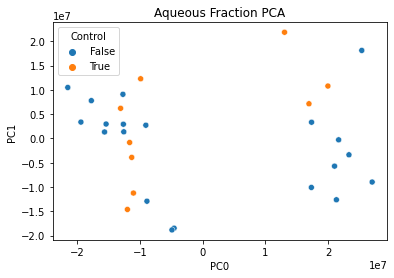

In [176]:
ax = sns.scatterplot(x=aqueous_pca_res[:,0], y=aqueous_pca_res[:,1],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Aqueous Fraction PCA")
plt.legend(title="Control")

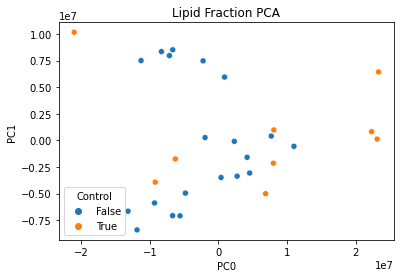

In [186]:
lipid_pca = PCA(n_components=3)
lipid_pca_res = lipid_pca.fit_transform(raw_lipid.drop(metabo_info_cols, 
                                                             axis=0).reindex(metabo_metadata.index))

ax = sns.scatterplot(x=lipid_pca_res[:,0], y=lipid_pca_res[:,1],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PC0", ylabel="PC1", title="Lipid Fraction PCA")
plt.legend(title="Control")

### PCoA with Bray Curtis

In [187]:
aqueous_bray = beta_diversity(metric="braycurtis",
                              counts=raw_aqueous.drop(metabo_info_cols, axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

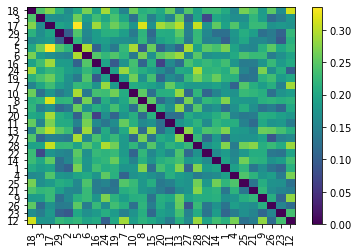

In [188]:
aqueous_bray

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02221753578741084 and the largest is 0.20095390757708628.
  warn(


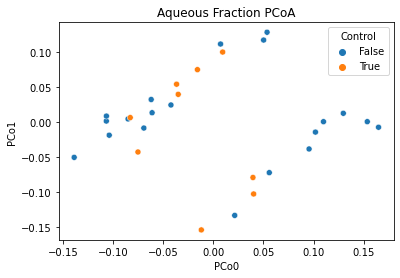

In [190]:
aqueous_pcoa_res = ordination.pcoa(aqueous_bray, number_of_dimensions=3)
ax = sns.scatterplot(x=aqueous_pcoa_res.samples["PC1"],
                     y=aqueous_pcoa_res.samples["PC2"],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PCo0", ylabel="PCo1", title="Aqueous Fraction PCoA")
plt.legend(title="Control")

/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.004372512892858705 and the largest is 0.24897841277437294.
  warn(


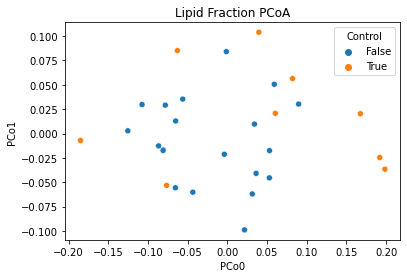

In [191]:
lipid_bray = beta_diversity(metric="braycurtis",
                              counts=raw_lipid.drop(metabo_info_cols, axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

lipid_pcoa_res = ordination.pcoa(lipid_bray, number_of_dimensions=3)
ax = sns.scatterplot(x=lipid_pcoa_res.samples["PC1"],
                     y=lipid_pcoa_res.samples["PC2"],
                     hue=metabo_metadata["PID"]=="Control")
ax.set(xlabel="PCo0", ylabel="PCo1", title="Lipid Fraction PCoA")
plt.legend(title="Control")

In [192]:
raw_aqueous

Compound,L-ISOLEUCINE**_1.428,Adenosine_4.092,Rehmaionoside C_7.64,Phenyl pyruvic acid_1.827,Pipecolic acid_2.82,C11 - 0.839,C13 - 1.093,C15 - 0.838,Piperidine_1.424,L-leucyl-L-proline_2.533,...,C2252 - 0.847,Valyl-Tyrosine_6.482,C2327 - 6.957,C2340 - 0.797,C2409 - 8.239,Tryptophyl-Leucine_7.759,Taraxinic acid 1'-O-beta-D-glucopyranoside_6.684,Lactiflorin_7.997,C2556 - 6.454,Leucyl-phenylalanine_7.238
1,17712000.0,146348.17,6398.4355,10674177.0,5768.1445,12170999.0,88575.1,9003215.0,61180444.0,657187.5,...,16241.985,14520.984,7045.5303,48157.723,0.00001,13797.909,0.00001,0.00001,27817.25,0.00001
10,17035938.0,607119.7,1455.5625,5485058.0,0.00001,12346700.0,116277.28,9638772.0,57270492.0,838093.0,...,19492.068,8145.5244,15454.732,56170.39,6789.9565,30013.299,0.00001,12012.743,140034.2,2327.0073
11,20275532.0,1020185.25,3444.505,39494272.0,13877.56,14251298.0,67781.93,10477635.0,48008460.0,1061066.8,...,23296.305,1707.6627,14735.302,68097.46,0.00001,30760.3,6226.627,2626.8083,144762.81,2836.1697
12,15365725.0,1551649.2,0.00001,40230988.0,0.00001,11668012.0,62352.82,8724246.0,61709096.0,1035873.1,...,15679.882,1070.6887,15523.82,30887.729,616.637,26817.178,3865.2488,13227.847,129917.61,1829.9155
13,13433810.0,407411.6,29579.545,40273104.0,10662.446,13293888.0,43721.836,9790668.0,32929592.0,1351724.8,...,17213.516,4386.807,31494.248,93080.14,0.00001,14800.214,23253.973,0.00001,42364.594,22198.748
14,16801808.0,263613.3,2022.8696,12512865.0,0.00001,14459168.0,199120.67,10588387.0,58218960.0,875465.9,...,22689.453,7726.437,16924.395,87264.78,11442.796,25459.69,7904.053,33873.86,75374.88,3554.2268
15,17612288.0,478496.34,3001.029,7217781.0,20740.877,12168036.0,86835.17,9516995.0,54037484.0,945324.6,...,19410.656,8967.472,16123.879,46603.91,3463.6724,5644.73,0.00001,1139.8162,102410.7,1949.9318
16,21075494.0,59944.477,12399.754,42260220.0,7902.9214,11747596.0,114403.43,8959424.0,41514740.0,825403.5,...,13761.421,11643.215,8375.084,68171.78,633.3845,19306.719,0.00001,0.00001,36755.85,0.00001
17,13896915.0,826037.0,3516.1975,3462700.8,13044.266,11739314.0,33273.504,8513096.0,55616704.0,809954.44,...,14403.929,12377.52,15073.355,20396.387,10933.08,5349.729,0.00001,0.00001,147136.0,1426.1476
18,8667443.0,79461.54,0.00001,13467822.0,23157.553,12462816.0,98734.93,9206984.0,33726200.0,818436.06,...,15843.771,5424.578,10506.706,74321.33,5231.727,1457.0148,0.00001,1196.4554,44170.01,14897.789
